In [126]:
import bilby as bb
import gwpopulation as gwpop
import matplotlib.pyplot as plt
import pandas as pd
from bilby.core.prior import PriorDict, Uniform
import os
import bilby
import numpy as np

In [127]:
#gwpop.set_backend("jax")

#xp = gwpop.utils.xp

project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#project_dir = '/home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/'

In [128]:
#netw = 'Asharp'
netw = 'CE4020ET123'
#mass_band = 'below_40'
#mass_band = '40-80'
mass_band = 'above_80'

if 'mass_band' in locals():
    print('Running for mass_band', mass_band)
    outdir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                          netw, 'mass_bands', mass_band, 'run04_gwfish_MDlow_mf_from_opt_SNR_injections_XPHM')
else:
    outdir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                          netw, 'run18_gwfish_mf_from_opt_SNR_injections_XPHM')
print(outdir)

Running for mass_band above_80
/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/gwpop_analysis_results/CE4020ET123/mass_bands/above_80/run04_gwfish_MDlow_mf_from_opt_SNR_injections_XPHM


In [129]:
result = bilby.result.read_in_result(filename=os.path.join(outdir, f'{netw}_result.hdf5'))
#result = bilby.result.read_in_result(filename=os.path.join(outdir, 'CE4020ET123_result.hdf5'))

## Add the new parameter which is peak of the curve

In [130]:
def z_peak_new(gamma, kappa, z_peak):
    new_peak = (gamma/(kappa-gamma))**(1/kappa) * (1+z_peak) - 1
    return(new_peak)

In [131]:
if "MDhigh" in outdir:
    true_params = {'gamma':1.7982, 'kappa':5.3226, 'z_peak':2.4199}
elif 'MDlow' in outdir:
    true_params = {'gamma':1.8111, 'kappa':5.2753, 'z_peak':1.4917}
else:
    true_params = {'gamma':1.8032, 'kappa':5.3023, 'z_peak':1.8362}
true_params['z_peak_new'] = z_peak_new(**true_params)

In [132]:
true_params

{'gamma': 1.8111,
 'kappa': 5.2753,
 'z_peak': 1.4917,
 'z_peak_new': 1.2034511573795865}

In [133]:
result.posterior

,gamma,kappa,log_likelihood,log_prior,z_peak
0,2.562569,7.985664,411.158288,-5.857933,1.674207
1,0.315705,2.168886,411.618703,-5.857933,3.426871
2,1.657474,3.913123,411.634900,-5.857933,2.036111
3,0.490335,15.242996,412.104547,-5.857933,3.982105
4,1.173646,7.875105,412.274692,-5.857933,3.034971
...,...,...,...,...,...
2654,0.038972,3.371357,418.716297,-5.857933,2.266474
2655,0.040880,3.458448,418.716818,-5.857933,2.358500
2656,0.001698,3.740512,418.718667,-5.857933,2.605517
2657,0.014946,3.464752,418.719049,-5.857933,2.421666


In [134]:
result.priors

{'gamma': Uniform(minimum=0, maximum=5, name=None, latex_label='$\\gamma$', unit=None, boundary=None),
 'kappa': Uniform(minimum=0, maximum=20, name=None, latex_label='$\\kappa$', unit=None, boundary=None),
 'z_peak': Uniform(minimum=0.5, maximum=4, name=None, latex_label='$z_{peak}$', unit=None, boundary=None)}

In [135]:
z_peak_new_posterior = z_peak_new(result.posterior['gamma'], 
                                  result.posterior['kappa'], 
                                  result.posterior['z_peak'])

In [136]:
result.posterior.loc[:, 'z_peak_new'] = z_peak_new_posterior

In [137]:
result.posterior.sort_values('z_peak_new')

,gamma,kappa,log_likelihood,log_prior,z_peak,z_peak_new
2475,0.000126,2.883554,418.502030,-5.857933,1.714381,-0.916364
784,0.016498,1.748948,417.309096,-5.857933,0.747073,-0.877925
511,0.030677,1.644043,416.870672,-5.857933,0.740267,-0.843737
1832,0.002916,2.389412,418.100044,-5.857933,1.825776,-0.829385
641,0.016554,1.891052,417.130219,-5.857933,1.438054,-0.800064
...,...,...,...,...,...,...
38,0.440568,8.551706,414.360798,-5.857933,3.946768,2.518761
21,0.089878,16.387450,413.740500,-5.857933,3.919334,2.581700
24,0.508897,10.065036,413.768756,-5.857933,3.824509,2.605046
13,0.240206,15.612388,413.370848,-5.857933,3.924457,2.772865


### Remove outlier points if need be

In [71]:
result.posterior = result.posterior.sort_values('z_peak_new').dropna()
result.posterior

,gamma,kappa,log_likelihood,log_prior,z_peak,z_peak_new
16,2.513331,5.313405,8092.000806,-5.857933,1.728309,1.673394
34,2.166916,5.117496,8092.860776,-5.857933,1.867672,1.699803
45,2.493482,5.192065,8093.211049,-5.857933,1.741861,1.700434
39,2.420897,5.058842,8093.037051,-5.857933,1.755740,1.709362
14,2.702810,5.757091,8091.786613,-5.857933,1.776082,1.717753
...,...,...,...,...,...,...
7,1.210434,5.401080,8090.830210,-5.857933,3.095893,2.254550
12,1.044902,6.082697,8091.683462,-5.857933,3.230840,2.266734
17,1.482031,6.258739,8092.072411,-5.857933,2.945564,2.272647
26,1.276927,5.901513,8092.518237,-5.857933,3.077568,2.278654


In [40]:
ci99 = (result.posterior['z_peak_new'] > np.quantile(result.posterior['z_peak_new'], 0.99))
negative_vals = (result.posterior['z_peak_new'] < 0)
drop_index = result.posterior[ci99 | negative_vals].index
#drop_index = result.posterior[negative_vals].index

In [41]:
drop_index

Index([ 808,  609,  605,  745,  762, 1705,  510, 1401,  388,  764,
       ...
         74,  148,  166,   86,   85,  133,    6,  155,  178,  214],
      dtype='int64', length=586)

In [42]:
result.posterior = result.posterior.drop(index=drop_index)
result.posterior

,gamma,kappa,log_likelihood,log_prior,z_peak,z_peak_new
2259,0.459577,1.773566,1382.157235,-5.857933,0.813951,0.003194
1622,0.065394,2.479882,1381.875292,-5.857933,3.300749,0.003562
2439,0.422094,1.610680,1382.242646,-5.857933,0.908871,0.003752
1632,0.384894,1.204640,1381.880006,-5.857933,0.882309,0.004917
2213,0.207433,1.726189,1382.130970,-5.857933,2.192970,0.007666
...,...,...,...,...,...,...
29,0.586279,3.683171,1377.634691,-5.857933,3.792779,2.050265
25,0.425151,6.192515,1377.548880,-5.857933,3.686883,2.076187
87,0.096465,9.439633,1378.883101,-5.857933,3.993940,2.076385
227,0.277729,0.539024,1379.942669,-5.857933,1.773009,2.105247


### Plot corner

In [138]:
true_params

{'gamma': 1.8111,
 'kappa': 5.2753,
 'z_peak': 1.4917,
 'z_peak_new': 1.2034511573795865}

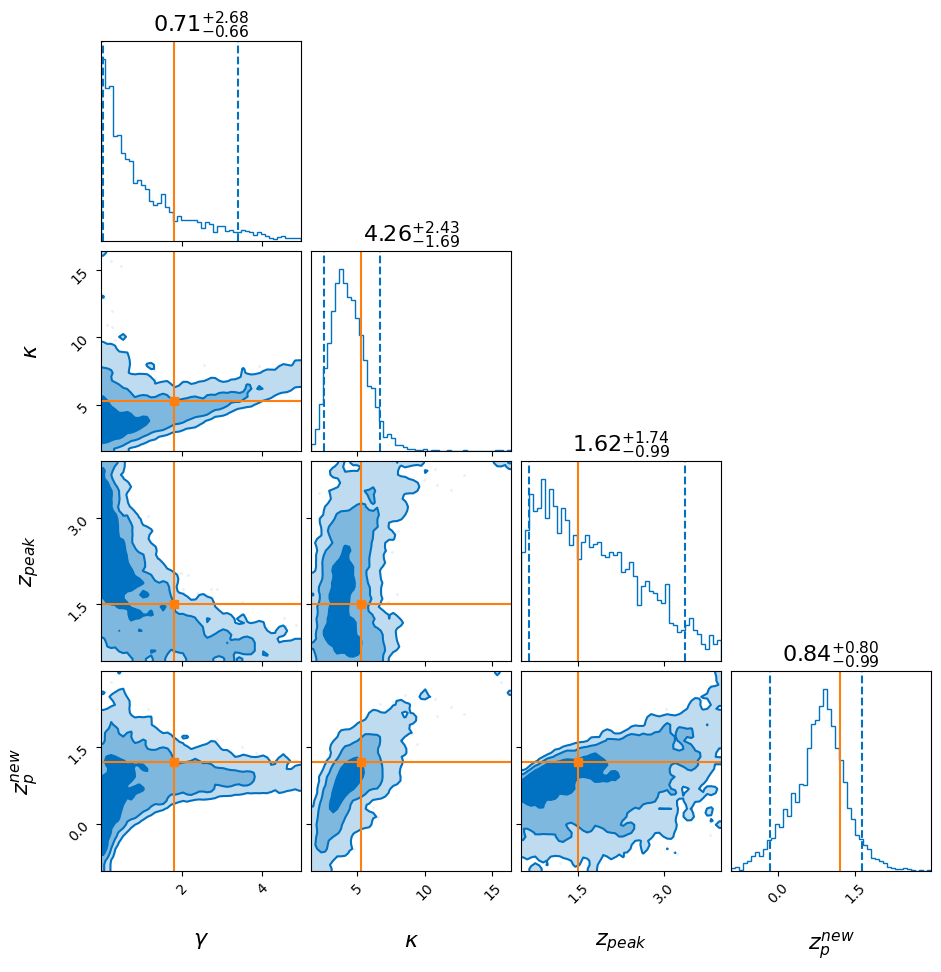

In [139]:
#result.plot_corner(parameters=list(true_params.keys()), outdir=outdir)
filename = f'{netw}_corner_with_truths.png'
#filename = 'CE4020ET123_corner_with_truths.png'
result.plot_corner(parameters=true_params, outdir=outdir, 
                   quantiles=(0.05, 0.95), 
                   filename=os.path.join(outdir, filename), labels=['$\\gamma$', '$\\kappa$', '$z_{peak}$', '$z_{p}^{new}$'])

## Check variance

In [74]:
#gwpop.set_backend("jax")

#xp = gwpop.utils.xp

project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#project_dir = '/home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/'

In [75]:
netw = 'Asharp'
#netw = 'CE4020ET123'
#mass_band = 'below_40'
#mass_band = '40-80'
#mass_band = 'above_80'
#outdir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
#                      netw, 'mass_bands', mass_band, 'run03_gwfish_mf_from_opt_SNR_injections_XPHM')
rundir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                      netw, 'run05_gwfish_mf_from_opt_SNR_injections_XPHM')

In [76]:
var_data = pd.read_csv(os.path.join(rundir, 'full_posterior_low_var_events.csv'))

In [77]:
var_data

,Unnamed: 0,key,sample_0
0,0,var_0,1.369832e-05
1,1,var_1,6.418322e-06
2,2,var_10,9.650263e-06
3,3,var_100,3.412744e-06
4,4,var_1000,3.183374e-06
...,...,...,...
4052,4052,var_995,1.788858e-06
4053,4053,var_996,7.791295e-06
4054,4054,var_997,4.116156e-06
4055,4055,var_998,2.848729e-07


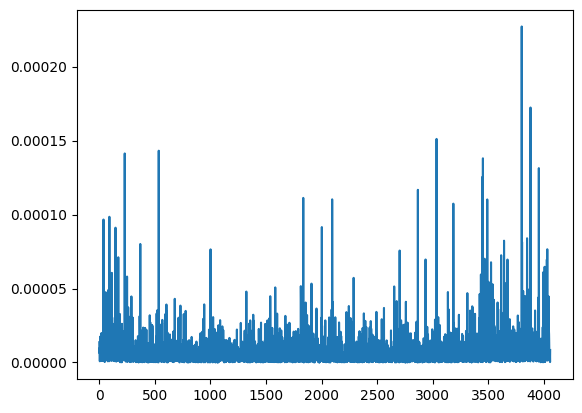

In [86]:
plt.plot(var_data['sample_0']);

In [82]:
np.sum(var_data['sample_0'])

0.02927127576058349

## Calculate variance

In [19]:
gwpop.set_backend("jax")
from gwpopulation.experimental.jax import JittedLikelihood, NonCachingModel
import jax

xp = gwpop.utils.xp

project_dir = '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/'
#project_dir = '/home/divyajyoti.nln/Cardiff_University/Next_gen_detectability/A-sharp-study/'

/home/divyajyoti/miniconda3/envs/gwpopulation/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/home/divyajyoti/miniconda3/envs/gwpopulation/lib/python3.11/site-packages/htcondor/__init__.py:49: UserWarning: Neither the environment variable CONDOR_CONFIG, /etc/condor/, /usr/local/etc/, nor ~condor/ contain a condor_config source. Therefore, we are using a null condor_config.
  _warnings.warn(message)


In [22]:
#netw = 'Asharp'
netw = 'CE4020ET123'
#mass_band = 'below_40'
#mass_band = '40-80'
mass_band = 'above_80'
outdir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
                      netw, 'mass_bands', mass_band, 'run01_original_cov_mf_from_opt_SNR_injections_XPHM')
#outdir = os.path.join(project_dir, 'gwpopulation', 'BBH', 'gwpop_analysis_results', 
#                      netw, 'run09_original_cov_mf_from_opt_SNR_injections_XPHM')

In [23]:
result = bilby.result.read_in_result(filename=os.path.join(outdir, f'{netw}_result.hdf5'))
#result = bilby.result.read_in_result(filename=os.path.join(outdir, 'CE4020ET123_result.hdf5'))

In [24]:
with open(os.path.join(outdir, 'README.txt'), 'r') as f:
    lines = [line.rstrip('\n').strip('\t') for line in f]
readme_dict = {}
for line in lines:
    words = line.split()
    if 'Posterior' in words:
        readme_dict['posterior_file'] = words[-1].replace('divyajyoti.nln/', 'divyajyoti/ACADEMIC/Projects/')
    elif 'Injections' in words:
        readme_dict['injections_file'] = words[-1].replace('divyajyoti.nln/', 'divyajyoti/ACADEMIC/Projects/')

In [25]:
readme_dict

{'posterior_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/mass_bands/CE4020ET123_CoBA10_2_PLP_z_MD_zmax_10_lmrd_22_no_spins_set3_z_posteriors_original_cov_49_events_pop_from_XPHM_above_80.pkl',
 'injections_file': '/home/divyajyoti/ACADEMIC/Projects/Cardiff_University/Next_gen_detectability/A-sharp-study/gwpopulation/BBH/injections/mass_bands/XPHM/CE4020ET123_CoBA10_SNR_2_pop_PLP_spin_prec_z_MD_zmax_10_lmrd_22_corrected_td_detected_injs_mf_from_opt_SNR_19852_points_above_80.pkl'}

In [26]:
# ## Load posteriors
posteriors = pd.read_pickle(readme_dict['posterior_file'])

In [127]:
# ## Load injections

import dill
from tqdm import tqdm

with open(readme_dict['injections_file'], "rb") as ff:
    injections = dill.load(ff)

In [128]:
z_max = 10
model = NonCachingModel(
    model_functions=[gwpop.models.redshift.MadauDickinsonRedshift(cosmo_model="Planck18", z_max=z_max)],
    #model_functions=[gwpop.models.redshift.PowerLawRedshift(z_max=8)],
)

vt = gwpop.vt.ResamplingVT(model=model, data=injections, n_events=len(posteriors))

likelihood = gwpop.hyperpe.HyperparameterLikelihood(
    posteriors=posteriors,
    hyper_prior=model,
    selection_function=vt,
)

priors = PriorDict()
priors['gamma'] = Uniform(minimum=0, maximum=5, latex_label="$\\gamma$")
priors['kappa'] = Uniform(minimum=0, maximum=20, latex_label="$\\kappa$")
priors['z_peak'] = Uniform(minimum=0.5, maximum=4, latex_label="$z_{peak}$")

parameters = priors.sample()
likelihood.parameters.update(parameters)

In [131]:
likelihood.ln_likelihood_and_variance?

Signature: likelihood.ln_likelihood_and_variance()
Docstring: Compute the ln likelihood estimator and its variance.
File:      ~/miniconda3/envs/gwpopulation/lib/python3.11/site-packages/gwpopulation/hyperpe.py
Type:      method

In [30]:
func = jax.jit(likelihood.generate_extra_statistics)
#func = jax.jit(likelihood.ln_likelihood_and_variance)

In [43]:
test_full_posterior_list = [func(parameters) for parameters in tqdm(result.posterior.to_dict(orient="records"), desc='constructing full posterior')]
test_full_posterior = pd.DataFrame(test_full_posterior_list).astype(float)

100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2726/2726 [00:15<00:00, 171.65it/s]


In [58]:
len(test_full_posterior_list)

2726

In [118]:
import numpy as np

keys_ln_bf = []
keys_var_event = []
keys_main = []
for key in test_full_posterior_list[0].keys():
    if 'ln_bf' in key:
        keys_ln_bf.append(key)
    elif 'var_' in key:
        keys_var_event.append(key)
    else:
        keys_main.append(key)
keys_ln_bf.extend(keys_main)
keys_var_event.extend(keys_main)
"""
# Convert keys to list of indices (functions) to avoid repeated lookups
extractors_ln_bf     = [lambda d, k=k: d[k] for k in keys_ln_bf]
extractors_var_event = [lambda d, k=k: d[k] for k in keys_var_event]
extractors_main      = [lambda d, k=k: d[k] for k in keys_main]

# Preallocate arrays
N = len(test_full_posterior_list)
data_ln_bf     = np.empty((N, len(keys_ln_bf)), dtype=np.float32)
data_var_event = np.empty((N, len(keys_var_event)), dtype=np.float32)
data_main      = np.empty((N, len(keys_main)), dtype=np.float32)

# Fill arrays using extractors
for i, d in tqdm(enumerate(test_full_posterior_list), total=N, desc='Converting to arrays'):
    data_ln_bf[i]     = [f(d) for f in extractors_ln_bf]
    data_var_event[i] = [f(d) for f in extractors_var_event]
    data_main[i]      = [f(d) for f in extractors_main]

# Vectorized conversion to dict of arrays
dict_ln_bf     = dict(zip(keys_ln_bf,     data_ln_bf.T))
dict_var_event = dict(zip(keys_var_event, data_var_event.T))
dict_main      = dict(zip(keys_main,      data_main.T))

"""
data_ln_bf = np.empty((len(test_full_posterior_list), len(keys_ln_bf)), dtype=np.float32)
data_var_event = np.empty((len(test_full_posterior_list), len(keys_var_event)), dtype=np.float32)
data_main = np.empty((len(test_full_posterior_list), len(keys_main)), dtype=np.float32)

for i, d in tqdm(enumerate(test_full_posterior_list), total=len(test_full_posterior_list), desc='Converting to dictionaries'):
    data_ln_bf[i] = [d[k] for k in keys_ln_bf]
    data_var_event[i] = [d[k] for k in keys_var_event]
    data_main[i] = [d[k] for k in keys_main]

# Convert to dict of arrays
dict_ln_bf = {k: data_ln_bf[:, i] for i, k in enumerate(keys_ln_bf)}
dict_var_event = {k: data_var_event[:, i] for i, k in enumerate(keys_var_event)}
dict_main = {k: data_main[:, i] for i, k in enumerate(keys_main)}

Converting to dictionaries: 100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 2726/2726 [00:01<00:00, 1526.93it/s]


In [108]:
df_main = pd.DataFrame(dict_main)

In [109]:
df_main.describe()

,gamma,kappa,log_likelihood,log_prior,selection,selection_variance,variance,z_peak
count,2726.000000,2726.000000,2726.000000,2726.000000,2726.000000,2.726000e+03,2726.000000,2726.000000
mean,1.907401,5.996839,348.920807,-5.857933,0.999426,2.852150e-06,0.006922,2.068088
std,1.418292,1.680055,0.973480,0.000000,0.001255,2.823121e-06,0.006776,0.851838
min,0.000085,2.126269,340.495758,-5.857933,0.995153,3.261948e-08,0.000150,0.505977
25%,0.687937,4.923723,348.497223,-5.857933,0.998645,1.178110e-06,0.002897,1.354990
50%,1.576846,5.878192,349.140945,-5.857933,0.999521,2.046581e-06,0.004986,1.916559
75%,2.985056,6.878242,349.599495,-5.857933,1.000288,3.619512e-06,0.008758,2.738614
max,4.998580,17.243456,350.289764,-5.857933,1.003706,3.582271e-05,0.086029,3.999785


In [113]:
df_main[result.search_parameter_keys + ["log_likelihood", "variance"]].corr()

,gamma,kappa,z_peak,log_likelihood,variance
gamma,1.000000,0.198562,-0.804147,0.311881,-0.050510
kappa,0.198562,1.000000,0.250383,-0.164009,-0.004891
z_peak,-0.804147,0.250383,1.000000,-0.320078,0.032138
log_likelihood,0.311881,-0.164009,-0.320078,1.000000,-0.807387
variance,-0.050510,-0.004891,0.032138,-0.807387,1.000000


### Save to files

In [112]:
import h5py
with h5py.File(os.path.join(outdir, 'ln_bf_vals_events.h5'), 'w') as f:
    for key, array in dict_ln_bf.items():
        f.create_dataset(key, data=array)

with h5py.File(os.path.join(outdir, 'var_vals_events.h5'), 'w') as f:
    for key, array in dict_var_event.items():
        f.create_dataset(key, data=array)

In [114]:
df_main.to_csv(os.path.join(outdir, 'full_posterior_main.csv'))

### Plot the scatter matrix

In [115]:
pd.plotting.scatter_matrix(
    df_main[["gamma", "kappa", "z_peak", "log_likelihood", "variance"]],
    alpha=0.5,
)
plt.tight_layout()
plt.savefig(os.path.join(outdir, 'param_variance_matrix.png'), dpi=300)